In [1]:
#Imports
import numpy as np
import scipy as sp
import healpy as hp
import histlite as hl
import csky as cy
import os
import gc
from glob import glob

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [38]:
#Overall TO DO:
#    * Energy:
#        * Different binning for different energy ranges with different template smoothing per energy bin
#        * Injected spectrum
#    * Seasons: Combining different years/runs/detector configurations
#        * Time integration of acceptance? 
#        * Loading of MC arrays
#    * Sensitivity:
#        * Should this be a class function, or just calculate outside of the class?

In [2]:
class LiMaStats:
    """For conducting binned calculations using Li, Ma (1983) statistical methods. 
    For binned sky map of IceCube event data.
    
    
    """
    def __init__(self, data, sig, grl, is_binned=False, savedir=None, name='LiMaBinnedTemplateAnalysis', 
                 template=None, gamma=2.7, cutoff=None, 
                 nside=128, num_bands=100, min_dec_deg=-80, max_dec_deg=80, 
                 verbose=False):
        """LiMaStats constructor
        
        Args:
            data: Path to numpy array(s) (directory or single file) containing  dtype=[('run', '<i8'), 
                                                 ('event', '<i8'),
                                                 ('subevent', '<i8'),
                                                 ('ra', '<f8'),
                                                 ('dec', '<f8'),
                                                 ('azi', '<f8'),
                                                 ('zen', '<f8'),
                                                 ('time', '<f8'),
                                                 ('logE', '<f8'),
                                                 ##('angErr', '<f8')])
                                                 
                OR: Path to numpy array of binned data (in this case, set is_binned=True)
                                     
            sig: Path to numpy array containing  dtype = [('run', int), 
                                                 ('event', int), 
                                                 ('subevent', int),
                                                 ('ra', float), 
                                                 ('dec', float),
                                                 ('true_ra', float), 
                                                 ('true_dec', float),
                                                 ('azi', float), 
                                                 ('zen', float), 
                                                 ('time', float),
                                                 ('logE', float), 
                                                 ('true_angErr', float), 
                                                 ('oneweight', float),     
                                                 ('true_energy', float)]
            
            grl: Path to numpy array with GRL runs
                                     
            is_binned: boolean, True if argument data is an array of binned_data, otherwise False (data will be binned)
            
            savedir: path to directory to save binned data. Default: None (don't save)
            
            name: unique name to identify analysis (used in file names when saving)
            
            template: path to template object/array or None
                TO DO:
                    * Rescale template nside for differing energy ranges
                                                            
            gamma: spectral index for detector acceptance and injections. 
                  #This should match the one used to create
                  #the template if using one saved by csky. 
                    
            cutoff: minimum template value to be considered an On bin
                TO DO (???):
                    * Implementation without need for cutoff???

            nside: integer for healpy nside (Default: 128)
                TO DO: 
                    * Allow nside to differ for different energy ranges
            
            num_bands: integer, number of equal-width bands in sin(Dec) (Default: 100, will have width ~0.02 in sin(Dec))
            
            min_/max_dec_deg: min and max declination in degrees for likelihood calculations.
            
            verbose: True for lots of output (Default: False)
            
            
        """
        if template is None:
            raise NotImplementedError('Current implementation can only perform template analysis!')
        elif cutoff is None:
            raise NotImplementedError('Current implementation requires a cutoff to define on/off bins!')
        
        print('Setting up:')
        
        self.name = name
        self.savedir = savedir
        cy.utils.ensure_dir(savedir)
        
        self.verbose = verbose
        
        self.gamma = gamma
        self.cutoff = cutoff
        self.nside = nside
        self.num_bands = num_bands
        
        self.sindec_bandedges = np.linspace(np.sin(np.radians(min_dec_deg)), np.sin(np.radians(max_dec_deg)), num_bands+1)
        self.band_width = (np.sin(np.radians(max_dec_deg)) - np.sin(np.radians(min_dec_deg))) / num_bands
        
        self.bin_thetas, self.bin_phis = hp.pix2ang(self.nside, np.arange(hp.nside2npix(self.nside))) 
        self.bin_ras = self.bin_phis
        self.bin_decs = np.pi/2.0 - self.bin_thetas
        
        self.bin_bands = np.digitize(np.sin(self.bin_decs), self.sindec_bandedges)
        
        self.grl = np.load(grl)
        
        if is_binned:
            self.binned_data = np.load(data)
            print(f'Load binned data <-- {data}')
            print(f'    Binned data loaded: Contains {len(self.binned_data)} bins with {np.sum(self.binned_data)} counts')
            if len(self.binned_data) != hp.nside2npix(self.nside):
                raise ValueError(f"Nside of loaded binned data is {hp.npix2nside(len(self.binned_data))}, but given nside is {self.nside}! You need to rebin your data.")
                
        else:
            self.load(data)
        
        self.sig_evs = np.load(sig)
        print(f'Load signal array <-- {sig}')
        smooth_sig = np.median(self.sig_evs['true_angErr'])
        print(f'    Median true angular error: {smooth_sig}')
        
        print(f'Load template <-- {template}')
        template = np.load(template, allow_pickle=True)
        
        
        if template.dtype == 'O':
            self.template = template.item()['template']
            if len(self.template) != hp.nside2npix(self.nside):
                print(f'Template nside does not match nside argument:')
                print(f'    Template: {hp.npix2nside(len(self.template))} --> Argument: {self.nside}')
                print('Adjusting resolution of template and making smoothed PDF... \n')
                
                self.template = hp.ud_grade(self.template, self.nside)
                self.create_template_pdf(smooth_sig)
                
            else:
                sigmas = np.radians(template.item()['sigmas_deg'])
                mindex = (np.abs(sigmas-np.degrees(smooth_sig))).argmin()
                self.template_pdf = template.item()['pdf_space_sig'][mindex]            
            
        else:
            self.template = template.copy()
            
            if len(self.template) != hp.nside2npix(self.nside):
                print(f'Template nside does not match nside argument:')
                print(f'    Template: {hp.npix2nside(len(self.template))} --> Argument: {self.nside}')
                print('Adjusting resolution of template and making smoothed PDF... \n')

                self.template = hp.ud_grade(self.template, self.nside)
                self.create_template_pdf(smooth_sig)
                
            else:
                self.create_template_pdf(smooth_sig)
            
        assert self.template.shape == self.template_pdf.shape, 'Template and template PDF shapes do not match...hmmm'
        assert len(self.template) == hp.nside2npix(self.nside), 'Number of bins in template does not match provided nside?!'
        assert len(self.template) == len(self.binned_data), 'Number of bins in template does not match number of bins in binned data!'

        print('***Setup complete!*** \n')
        
    def bin_data(self, data, verbose=None):#, truth=False, seed=None):
        """
        Convert event data into bin counts using healpy. 
        
        Args:
            data: data event array(s)
            
            verbose: True to show more output (Defaults to class's initited value)
            
        #    truth: Whether to use true event locations (True), or scramble in right ascension (False)
        #
        #    seed: integer, Seed for numpy.random.default_rng() used to scramble events (Default: None, meaning unpredictable)
        """
        
        if verbose is None:
            verbose = self.verbose
            
        event_decs = data['dec']
        event_ras = data['ra']
        #if truth:
        #    event_ras = self.data['ra']
        #else:            
        #    rng_scramble = np.random.default_rng(seed=seed)                
        #    event_ras = 2.0 * np.pi * rng_scramble.random(size=len(self.data['ra']))
        
        if verbose:
            print(f'Binning {len(event_ras)} events with nside={self.nside}...that is {hp.nside2npix(self.nside)} bins! Wow!', end=' ')
        
        event_pix_nums = hp.ang2pix(self.nside, np.pi/2.0 - event_decs, event_ras)
        
        if verbose:
            print('--> Binning Done.')

        return np.bincount(event_pix_nums)
    
    def load(self, path, verbose=None):
        """
        Loads data and bins it.
        
        Args:
            path: path to directory containing data files or path to a data file
            
            verbose: True to show more output (Defaults to class's initited value)
            
        """
        if verbose is None:
            verbose = self.verbose
        assert (os.path.isdir(path) or os.path.isfile(path)), f"Expected path to directory or file, got: {path}"
        
        print(f'Loading and binning data from {path}')
        if os.path.isdir(path):
            files_like = path+'/*.npy'
            file_list = sorted(glob(files_like))
            binned_data = np.zeros(hp.nside2npix(self.nside))
            for file in file_list:
                data = np.load(file)
                mask = np.isin(data['run'], self.grl)
                data = data[mask]
                
                if verbose:
                    print(f'    {file} | ', end=' ')
                binned_data = binned_data + self.bin_data(data)
            
            self.binned_data = binned_data
        
        else:
            data = np.load(path)
            mask = np.isin(data['run'], self.grl)
            data = data[mask]
            
            if verbose:
                print(f'    {path} | ', end=' ')
            self.binned_data = self.bin_data(data)
            
        del data
        gc.collect()
        print('--> Data Loading Done. \n')
        
        if self.savedir is not None:
            savefile = f'{self.savedir}/{self.name}.binned_data.npy'
            np.save(savefile, self.binned_data)
            print(f'Binned data saved to --> {savefile}')
            

        return
        
    
    def create_bg_acc_spline(self, skw={}):
        """
        Create detector acceptance spline (*background*, sinDec-dependent) for weighted product of likelihoods across declinations.
        
        Pieces taken from csky.
        
        TO DO: Is this right?
        
        Args:          
            skw: histlite.Hist.spline_fit kwargs
        
        Returns: histlite spline object
        
        """
                
        h_counts = hl.hist(np.sin(self.bin_decs), weights=self.binned_data)
        h = h_counts.normalize(density=True) / (2*np.pi)
        hrange = h.range[0]
        
        skw.setdefault('s', 0)
        skw.setdefault('k', 2)
        skw.setdefault('log', True)
        s_hl = h.spline_fit(**skw)
        
        self.bg_acc_spline = s_hl.spline
        
        return self.bg_acc_spline
    
    def create_signal_acc_spline(self, skw={}):
        """
        Create detector acceptance spline (*signal*, sinDec-dependent) for weighted product of likelihoods across declinations.
        
        Pieces taken from csky.
        
        TO DO: Is this right? Spline could use some work.
        
        Args:
            skw: histlite.Hist.spline_fit kwargs (Unused.)
        
        Returns: scipy spline object
        
        """
        
        '''
        xs = np.r_[self.bin_decs[0], self.bin_decs, self.bin_decs[-1]]
        ws = np.r_[(self.template_pdf)[0], self.template_pdf, (self.template_pdf)[-1]]
        h_counts = hl.hist(xs, weights=ws, bins=30)   #Evaluate accuracy of this spline especially at poles
        h = h_counts.normalize(density=True) / (2*np.pi)
        hrange = h.range[0]
        
        skw.setdefault('s', 0)
        skw.setdefault('k', 2)
        skw.setdefault('log', True)
        s_hl = h.spline_fit(**skw)
        
        self.signal_acc_spline = s_hl.spline
        '''
        
        print('Using csky to obtain acceptance spline...')
        a = cy.utils.Arrays(init=self.sig_evs, convert=True)
        spl = cy.pdf.SinDecAccParameterization(a).s
        print('--> Acceptance Spline Done.')
        
        self.signal_acc_spline = spl

        return self.signal_acc_spline
    
    def get_acc_from_spline(self, sindec, acc='signal'):
        """
        Used spline to get acceptance at a give sin(Dec).
        
        Args:
            sindec: Sine of declination(s)
            
            acc: One of "signal" or "bg" for which acceptance spline to use. (Default: 'template')
            
        Returns: acceptance(s) for provided sin(Dec).
        
        """
        
        if acc == 'signal':
            try:
                out = np.exp(self.signal_acc_spline.ev(self.gamma, sindec))
            except AttributeError:
                print('Signal acceptance spline not yet created. Creating now... \n')
                self.create_signal_acc_spline()
                out = np.exp(self.signal_acc_spline.ev(self.gamma, sindec))
                
            return out
                
        elif acc == 'bg': #This is probably not going to be used
            try:
                out = np.exp(self.bg_acc_spline(sindec))
            except AttributeError:
                print('Background acceptance spline not yet created. Creating now... \n')
                self.create_bg_acc_spline()
                out = np.exp(self.bg_acc_spline(sindec))
                
            return out
        
        else:
            raise NotImplementedError('Argument spline must be one of ["signal", "bg"].')
            
    def create_template_pdf(self, smooth_sig):
        """
        Applies detector acceptance to template and smooths, normalizes.
        
        Args:
            smooth_sig: Sigma (in radians) for gaussian smoothing using healpy.smoothing(x, sigma=smooth_sig)

        """
        
        print("Applying detector acceptance to template...")
        #Make acceptance spline
        self.create_signal_acc_spline()
        #Apply spline
        template_acc = self.template * self.get_acc_from_spline(np.sin(self.bin_decs))
      
        template = self.template.copy()

        def smooth(temp, smooth_sig):
            temp_pdf = temp / (np.sum(temp))
            mask = (self.template > 0) & (temp_pdf <= 0)
            temp_pdf[mask] = hp.UNSEEN
            
            #Smooth
            #template_pdf = self.template.copy()
            temp_pdf = hp.smoothing(temp_pdf, sigma=smooth_sig)
            #Reset nonsensical values 
            temp_pdf[mask] = 0
            temp_pdf[temp_pdf < 1e-12] = 1e-12
            dec_mask = (self.bin_decs<np.radians(85)) & (self.bin_decs>np.radians(-85))
            #Re-normalize
            temp_pdf = temp_pdf / ( np.sum(temp_pdf[dec_mask]) * hp.nside2pixarea(self.nside) )
            
            return temp_pdf
        
        self.template_smoothed = smooth(template, smooth_sig)
        self.template_acc_smoothed = smooth(template_acc, smooth_sig)
        
        #This, self.template_pdf, is what gets used in defining N_on and N_off.
        #The above, self.template_acc_smoothed, will always be used for injections. 
        self.template_pdf = self.template_acc_smoothed
        #self.template_pdf = self.template_smoothed
        print('--> Template PDF Done. \n')
        
        return

    def template_counter(self, sindec):
        """
        Gets on and off counts and alpha by performing (weighted) sum of bin counts in a given sindec band. 
        On bins are defined as having template weights greater than or equal to the cutoff.
        OLD: Alpha is the ratio of number of on bins to off bins, since each bin has the same area.
        NEW: Alpha is the ratio of the sum of on template values to off template values.
        
        Args:
            sindec: Sine of declination (radians) for band of bins
            
        *Note*: Data may not have been re-binned after injections! 
            
        Returns: alpha, number of On counts, number of Off counts
        """
        bin_band_idx = self.bin_bands
        bin_idx = np.digitize(sindec, self.sindec_bandedges)
        
        mask_sindec = (bin_band_idx == bin_idx)
            
        template_dec = self.template_pdf[mask_sindec]
        binned_data_dec = self.counts[mask_sindec]
        
        assert template_dec.shape == binned_data_dec.shape
        
        mask_cutoff = (template_dec > self.cutoff)
        
        N_on = np.sum(np.multiply(template_dec[mask_cutoff] , binned_data_dec[mask_cutoff]))
        N_off = np.sum(binned_data_dec[~mask_cutoff])                                  
        #alpha = np.sum(mask_cutoff) / np.sum(~mask_cutoff)                                #Unweighted ratio of # of on to off bins
        #alpha = np.sum(template_dec[mask_cutoff]) / np.sum(template_dec[~mask_cutoff])    #Weighted sum, i.e. ratio of template value sums
        alpha = np.sum(template_dec[mask_cutoff]) / np.sum(~mask_cutoff)                  #Weighted to unweighted ratio
        
        return alpha, N_on, N_off
    
    def log_likelihood_ratio(self, sindec, verbose=None):
        """
        Calculation of LOG likelihood ratio for the given declination.
        
        Args:
            sindec: Sine of declination for band of bins
            
            verbose: True to show more output (Defaults to class's initited value)
            
        *Note*: Data may not have been re-binned after injections! 
            
        Returns: LOG likelihood ratio (float)
        
        """
        if verbose is None:
            verbose = self.verbose
        if verbose:
            print(f'Getting log likelihood ratio for bins with sin(Dec)={sindec} +/- {self.band_width}:')
        
        alpha, N_on, N_off = self.template_counter(sindec)
        
        if verbose:
            print(f'    alpha = {alpha}')
            print(f'    N_on  = {N_on}')
            print(f'    N_off = {N_off}')
        
        if alpha == 0.0:
            llr = 1.0
        elif alpha == np.inf:
            llr = 0.0
        else:
            first_term = np.log( (alpha / (1+alpha)) * ((N_on + N_off) / N_on) ) * N_on
            second_term = np.log( (1 / (1+alpha)) * ((N_on + N_off) / N_off) ) * N_off

            llr = first_term + second_term

        if verbose:
            print(f' * Log Likelihood Ratio for DEC={np.degrees(np.arcsin(sindec))} deg: {llr}')
            print(' ')

        return llr
        
    def allsky_llr(self, acc='signal', verbose=None):
        """
        Get likelihood ratios for every declination and combine.
        
        Args:
            acc: One of "signal" or "bg" for which acceptance spline to use. (Default: 'signal')
            
            verbose: True to show more output (Defaults to class's initited value)
        
        *Note*: Data may not have been re-binned after injections! 
        
        Returns: the all-sky likelihood ratio (lambda in Li, Ma (1983)), and dictionary of {sindec: llr} for sin(Dec) bands
            
        """
        if verbose is None:
            verbose = self.verbose
        sindec_list = self.sindec_bandedges[:-1] + self.band_width/2.0
        
        sindec_llrs = {}
        sindec_accs = {}
        
        if acc not in ['signal', 'bg']:
            raise ValueError('Argument spline must be one of ["signal", "bg"].')
        
        if verbose:
            print(f'==== Getting all-sky likelihood ratio for nside={self.nside} with {acc} acceptances ====')
        for sindec in sindec_list:
            sindec_llrs[sindec] = self.log_likelihood_ratio(sindec, verbose=verbose)
            sindec_accs[sindec] = self.get_acc_from_spline(sindec, acc=acc)
        
        llrs = np.array(list(sindec_llrs.values()))
        accs = np.array(list(sindec_accs.values()))
        allsky_llr = np.sum(accs * llrs)            #Weighted sum of log(LHR)s 
        #allsky_llr = np.sum(llrs)                   #Without acceptance weighting
        
        sindec_llrs = {'sindec': sindec_llrs}
        sindec_accs = {'sindec': sindec_accs}
        
        return allsky_llr, sindec_llrs, sindec_accs
    
    def get_one_llr(self, n_sig=0, acc='signal', truth=False, seed=None, verbose=None):
        """
        Obtains a single all-sky likelihood ratio.
        
        Args:
            n_sig: number of (signal) events to inject (Default: 0). Only used if truth=False
            
            acc: One of "signal" or "bg" for which acceptance spline to use. (Default: 'signal')
        
            truth: Whether to use true event locations (True), or scramble in right ascension (False)
        
            seed: integer, Seed for numpy.random.default_rng() used to scramble events and pick injection locations
                  (Default: None, meaning unpredictable)
                  
            verbose: True to show more output (Defaults to class's initited value)
            
        Returns: dictionary containing all-sky llr, sinDec llrs, and sinDec acceptances
        
        """
        if verbose is None:
            verbose = self.verbose
        
        if truth:
            self.counts = self.binned_data.copy()
            allsky_llr, sindec_llrs, sindec_accs = self.allsky_llr(acc=acc, verbose=verbose)
        else:
            self.counts = self.scrambler(seed=seed)
            if n_sig == 0:
                allsky_llr, sindec_llrs, sindec_accs = self.allsky_llr(acc=acc, verbose=verbose)
            else:
                self.template_injector(n_sig=n_sig, seed=seed)
                allsky_llr, sindec_llrs, sindec_accs = self.allsky_llr(acc=acc, verbose=verbose)
                
        result = {'allsky_llr': allsky_llr, 
                  'sindec_llrs': sindec_llrs, 
                  'sindec_accs': sindec_accs}
        
        if verbose:
            print(' --> One All Sky LLR Done.')
        return result
    
    def get_many_llrs(self, num, n_sig=0, acc='signal', seed=None, verbose=None):
        """
        Obtains multiple likelihood ratios
        
        Args:
            num: integer, number of llrs to compute
            
            n_sig: number of (signal) events to inject (Default: 0)
                        
            acc: One of "signal" or "bg" for which acceptance spline to use. (Default: 'signal')
            
            seed: integer, seed used to create multiple new seeds for scrambles (Default: None, unpredictable)
            
            verbose: True to show more output (Defaults to class's initited value)
            
        Returns: dictionary with {'n_sig': n_sig, 'seed': {new_seed: allsky_llr} }
        
        """
        print(f'Calculating {num} log likelihood ratio(s) with {n_sig} injected event(s)...')
        if verbose is None:
            verbose = self.verbose
            
        llrs = {}
        
        num = int(num)
        if num < 1:
            raise ValueError(f'num must be a positive integer, got: {num}')
        elif num == 1:
            llrs[seed] = self.get_one_llr(n_sig=n_sig, seed=seed, acc=acc, verbose=verbose)['allsky_llr']
        else:
            rng_seed = np.random.default_rng(seed)
            for i in range(1, num+1):
                new_seed = rng_seed.integers(int(1e9))

                llrs[new_seed] = self.get_one_llr(n_sig=n_sig, seed=new_seed, acc=acc, verbose=verbose)['allsky_llr']
                    
        llrs = {'n_sig': n_sig, 'seed': llrs}
        print(f'--> {num} All Sky LLRs Done!')
        return llrs        
        
    def get_TS_from_llr(self, llr):
        """
        Simple conversion to TS from a given (array of) log likelihood ratio(s).
        
        Args:
            llr: float or array of floats, likelihood ratio to be converted to TS
        
        Returns: float or array of floats, TS
            
        """
        try:
            ts = -2.0 * llr
        except TypeError:
            try:
                llrs = np.array(list(llr['seed'].values()))
            except KeyError:
                try:
                    llrs = np.array(list(llr.values()))
                except:
                    raise NotImplementedError("The type of the llr argument provided is not supported.")
            
            ts = -2.0 * llrs
        
        return ts
    
    def fit_TS_chi2(self, tss):
        """
        Fit distribution of TSs > 0 with a chi-squared funtion.
        
        Args:
            tss: array of TSs
        
        Returns: Chi2 degrees of freedom, location, scale parameters
        
        """
        self.eta = np.mean(tss>0)
        self.df, self.loc, self.scale = sp.stats.chi2.fit(tss[tss>0], 1)     # 1 indicates starting guess for chi2 degrees of freedom
        self.chi2_fit = sp.stats.chi2(self.df, self.loc, self.scale)
        
        print('Chi2 distribution fit to TS > 0 with:')
        print(f'    DoF: {self.df}')
        print(f'    loc: {self.loc}')
        print(f'    scale: {self.scale}')
        print(f'    eta: {self.eta}')
        
        return 
    
    def TS_to_p(self, ts, bg=None, use='fit', dof=1):
        """
        Converts given TS to p-value using chosen method.
        
        Args:
            ts: float or array of floats, TS to convert to p-value
            
            bg: None or array, background TSs (Default: None)
            
            use: string, which method/distribution to use.
                 One of 'fit', 'chi2_dof', or 'hist'. If 'fit' and argument bg is not None, will fit a Chi2 distribution to\
                 the provided bg distribution. If 'chi2_dof', will use a Chi2 with provided dof and loc=0, scale=1. If \
                 'hist', will use the bg TSs themselves. (Default: 'fit')
                 
            dof: Number of degrees of freedom to use if use='chi2_ndof'
            
        Returns: p-value(s)
                 
        """
        if use not in ['fit', 'chi2_dof', 'hist']:
            raise ValueError(f'Argument use must be one of "fit", "chi2_dof", or "hist", got "{use}"')
            
        if (use == 'chi2_ndof') or (bg is None):
            #TS --> p using generic Chi2 function
            #Necessary if no BG distribution is provided
            
            print(f'Calculating p-value(s) using a Chi2 Distribution with {dof} degrees of freedom...')
            p = sp.stats.chi2.sf(ts, df=dof)
            print(f'    p = {p}')
            
        elif use == 'fit':
            #TS --> p using Chi2 fit
            #Requires BG dist to be provided
            
            print(f'Calculating p-value(s) using a Chi2 Distribution fit to provided background...')
            self.fit_TS_chi2(bg)
            p = self.chi2_fit.sf(ts)
            print(f'    p = {p}')
            
        elif use == 'hist':
            #TS --> p using distribution directly
            #Requires BG dist to be provided
            
            print(f'Calculating p-value(s) using background TSs distribution directly...')
            p = np.array([np.mean(bg >= t) for t in ts])
            print(f'    p = {p}')
            
        return p
    
    def create_bin_count_spline(self):
        """
        Creates a 2d spline of bin counts vs bin sin(dec) for use in creating scrambles with self.scrambler
        
        """
        bs = [-np.pi/2] + list(np.unique(self.bin_decs)[:-1] + .5*np.diff(np.unique(self.bin_decs))) + [np.pi/2]
        h = hl.hist((self.binned_data, np.sin(self.bin_decs)), bins = (np.arange(0,np.max(self.binned_data)+1), np.sin(bs)))

        skw = {}
        skw.setdefault('s', 0)
        skw.setdefault('kx', 2)
        skw.setdefault('ky', 2)
        s_hl = h.spline_fit(**skw)
        
        self.bin_count_spline = s_hl.spline
        
        return
    
    def scrambler(self, seed=None):
        """
        Gets a map of "scrambled" counts by sampling from self.bin_count_spline with given sindec
        
        Args:       
            seed: integer, Seed for numpy.random.default_rng() used to scramble events and pick injection locations
                  (Default: None, meaning unpredictable)
        
        """
        if not hasattr(self, 'bin_count_spline'):
            self.create_bin_count_spline()
        
        unique_decs = np.unique(self.bin_decs)
        
        rng_scramble = np.random.default_rng(seed=seed)
        counts = np.zeros_like(self.binned_data)
        for dec in unique_decs:
            mask = (self.bin_decs == dec)
            crange = np.arange(0, np.max(self.binned_data[mask])+1, 1)
            weights = np.clip(self.bin_count_spline.ev(crange, np.sin(dec)), a_min=1e-12, a_max=None)
            counts[mask] = rng_scramble.choice(crange, size=np.sum(mask), p=weights/np.sum(weights))
            
        return counts
            
    
    def template_injector(self, n_sig, seed=None, verbose=None):
        """
        Injects events based on template probabilities.
        
        Args:
            n_sig: number of events to inject (with poisson fluctuations)
            
            seed: integer, Seed for numpy.random.default_rng() used to pick injection locations (Default: None, meaning unpredictable)
            
        """
        #NOTE: energy not yet implemented. Gamma is unused here!
        if verbose is None:
            verbose = self.verbose
                           
        rng_inj = np.random.default_rng(seed=seed)
        poisson_n_sig = rng_inj.poisson(lam=n_sig)
        
        #Injection bins are choice of ON bins (defined by self.template_pdf > self.cutoff)
        #The probability of choice within the ON bins is always including the acceptance, whether template_pdf does or not. 
        mask = (self.template_pdf > self.cutoff)
        inj_choice = np.arange(hp.nside2npix(self.nside))[mask]
        inj_probs = self.template_acc_smoothed[mask] / np.sum(self.template_acc_smoothed[mask])
        self.inj_bins = rng_inj.choice(inj_choice, size=poisson_n_sig, p=inj_probs)

        if verbose:
            print(f'Injecting {n_sig} events in "On" bins according to template+acceptance probabilities with poisson fluctuation ({poisson_n_sig})...')
        
        #Get unique injection bins and times to inject in each bin
        bin_nums, bin_injs = np.unique(self.inj_bins, return_counts=True)
        
        #Add injections to counts in respective bins
        self.counts[bin_nums] += bin_injs
                
        return          
        

In [3]:
#data_arr = np.load('./test/IC86_2016_exp.npy', allow_pickle=True)
#sig_arr = np.load('./test/IC86_2016_MC.npy', allow_pickle=True)
#template_arr = np.load('./templates/Fermi-LAT_pi0_map.npy', allow_pickle=True)

In [3]:
#data_path = './test/IC86_2016_exp.npy'
#sig_path = './test/IC86_2016_MC.npy'
#template_path = './templates/Fermi-LAT_pi0_map.npy'

In [4]:
data_path = 'data/level2/binned/Level2_2020.binned_data.npy'
sig_path = 'data/level2/sim/npy/Level2_sim.npy'
grl_path = 'GRL.npy'
template_path = 'templates/Fermi-LAT_pi0_map.npy'

In [5]:
lima_bean = LiMaStats(data_path, sig_path, grl_path, is_binned=True, savedir='data/level2/binned', name='Fermi_pi0_bothAcc', 
                 template=template_path, gamma=2.7, cutoff=10**(-1.0), 
                 nside=128, num_bands=50, min_dec_deg=-80, max_dec_deg=80, verbose=False)

Setting up:
Load binned data <-- data/level2/binned/Level2_2020.binned_data.npy
    Binned data loaded: Contains 196608 bins with 1067835703.0 counts
Load signal array <-- data/level2/sim/npy/Level2_sim.npy
    Median true angular error: 0.1039151817504035
Load template <-- templates/Fermi-LAT_pi0_map.npy
Applying detector acceptance to template...
Using csky to obtain acceptance spline...
  * gamma = 4.0000 ...
--> Acceptance Spline Done.
--> Template PDF Done. 

***Setup complete!*** 



In [ ]:
trials = lima_bean.get_many_llrs(num=1000, n_sig=1000000, acc='signal', seed=12, verbose=False)

In [ ]:
np.save('trials/sig/bothAcc/trials1000_nsig1000000_seed12_bothAcc_cutoff1.0.npy', trials)

In [40]:
tss = lima_bean.get_TS_from_llr(np.array(list(trials['seed'].values())))

In [3]:
tbb = np.load('trials/bkg/bothAcc/trials100_seed12_bothAcc_cutoff1.0.npy', allow_pickle=True)
tsb = np.load('trials/sig/bothAcc/trials100_nsig1000000_seed12_bothAcc_cutoff1.0.npy', allow_pickle=True)

tbc = np.load('trials/bkg/combAcc/trials100_seed12_combAcc_cutoff1.2.npy', allow_pickle=True)
tsc = np.load('trials/sig/combAcc/trials100_nsig1000000_seed12_combAcc_cutoff1.2.npy', allow_pickle=True)

tbt = np.load('trials/bkg/tempAcc/trials100_seed12_tempAcc_cutoff1.0.npy', allow_pickle=True)
tst = np.load('trials/sig/tempAcc/trials100_nsig1000000_seed12_tempAcc_cutoff1.0.npy', allow_pickle=True)

In [20]:
both_b = -2*np.array(list(tbb.item()['seed'].values()))
both_s = -2*np.array(list(tsb.item()['seed'].values()))

comb_b = -2*np.array(list(tbc.item()['seed'].values()))
comb_s = -2*np.array(list(tsc.item()['seed'].values()))

temp_b = -2*np.array(list(tbt.item()['seed'].values()))
temp_s = -2*np.array(list(tst.item()['seed'].values()))

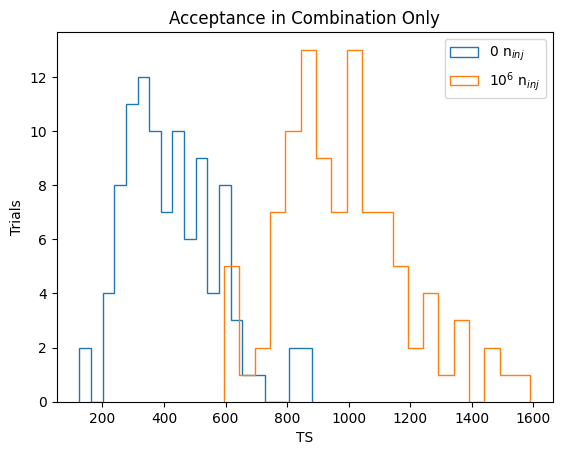

In [28]:
plt.figure(facecolor='w')
plt.hist(comb_b, bins=20, histtype='step', label=r'0 n$_{inj}$')
plt.hist(comb_s, bins=20, histtype='step', label=r'10$^6$ n$_{inj}$')
plt.xlabel('TS')
plt.ylabel('Trials')
plt.title('Acceptance in Combination Only')
plt.legend()
plt.savefig('plots/combAcc_TScomparison.png')
plt.show()

In [7]:
temp_wAcc = np.load('data/level2/binned/Fermi_pi0_wAcc_gamma2.7_sigma0.1.template_pdf.npy')
temp = np.load('data/level2/binned/Fermi_pi0_noAcc_gamma2.7_sigma0.1.template_pdf.npy')
pi0 = np.load('templates/Fermi-LAT_pi0_map.npy')

<Figure size 640x480 with 0 Axes>

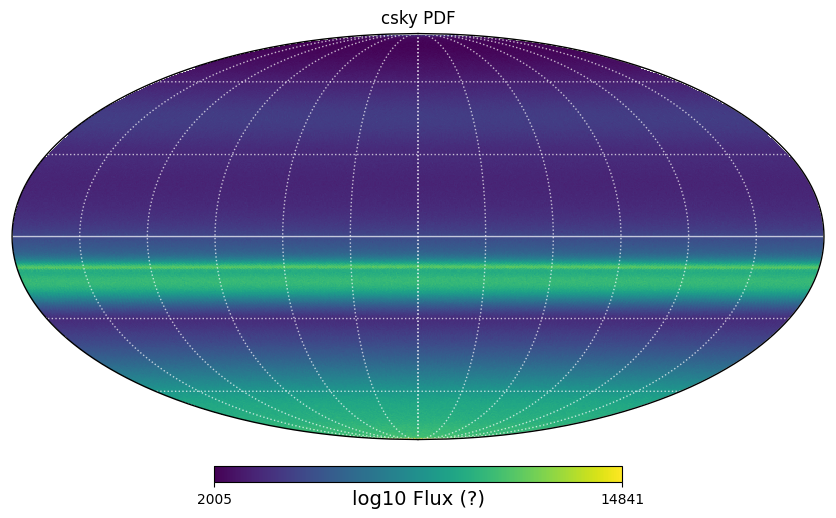

In [13]:
plt.figure(facecolor='w')
#x = template_arr.item()['template']
#x1 = hp.smoothing(x, sigma=np.radians(.5)) * np.exp(q(2.7,np.sin(decs)))  
#x1 /= np.sum(x1)*pixarea
#x3 = template_arr.item()['pdf_space_sig'][1]

x = lima_bean.binned_data

mask = (x > 10**(-1))
#x[mask] = hp.UNSEEN

hp.mollview(x, unit='log10 Flux (?)', rot=(180,0,0), title='csky PDF') 
hp.graticule(30, color='w', alpha=0.7)
plt.show()

In [11]:
#load and append bkg trials
where_acc = 'combAcc'

filelist = sorted(glob(f'/data/user/mcampana/analysis/binned_tracks/trials/bkg/{where_acc}/trials*.npy'))
bg_tss = np.array([])
c = 0
for f in filelist:
    c += 1
    arr = np.load(f, allow_pickle=True)
    bg_tss = np.append(bg_tss, -2.0 * np.array(list(arr.item()['seed'].values())))

print(f'Loaded {c} files of background trials.')

med_bg_ts = np.median(bg_tss)

Loaded 100 files of background trials.


In [12]:
#load and append sig trials
#nsigs = np.sort(np.array(os.listdir(f'/data/user/mcampana/analysis/binned_tracks/trials/sig/{where_acc}/nsig/'), dtype=int))
nsigs = np.array([250000, 500000, 750000])
sig_tss = {}
passing = {}
for nsig in nsigs:
    filelist = sorted(glob(f'/data/user/mcampana/analysis/binned_tracks/trials/sig/{where_acc}/nsig/{nsig}/trials*.npy'))
    tss = np.array([])
    c = 0
    for f in filelist:
        c += 1
        arr = np.load(f, allow_pickle=True)
        tss = np.append(tss, -2.0 * np.array(list(arr.item()['seed'].values())))
        
    sig_tss[nsig] = tss
    
    #passing fractions
    passing[nsig] = np.mean(tss > med_bg_ts)

passing[0] = .5
passing[1000000] = 1.0

In [ ]:
plt.figure(facecolor='w')
bins = np.linspace(0,8000,50)
plt.hist(bg_tss, bins=bins, histtype='step')
plt.hist(sig_tss[250000], bins=bins, histtype='step')
plt.hist(sig_tss[500000], bins=bins, histtype='step')
plt.hist(sig_tss[750000], bins=bins, histtype='step')
plt.vlines(med_bg_ts, 0, 850, linestyle='--', color='k')
plt.xlim(0, 6000)
plt.show()

In [4]:
from scipy.interpolate import interp1d, splrep, splev

In [13]:
xs = np.linspace(0,1000000,50)
f = interp1d(list(passing.keys()), list(passing.values()), kind='quadratic')
ys = f(xs)

In [14]:
ys_comb = ys
passing_comb = passing

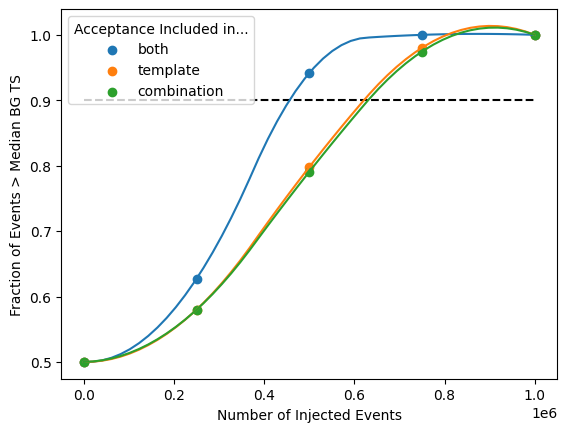

In [15]:
plt.figure(facecolor='w')
plt.scatter(passing_both.keys(), passing_both.values(), label='both')
plt.scatter(passing_temp.keys(), passing_temp.values(), label='template')
plt.scatter(passing_comb.keys(), passing_comb.values(), label='combination')
plt.hlines(0.9, 0, 1000000, linestyle='--', color='k')
plt.plot(xs, ys_both, color='C0')
plt.plot(xs, ys_temp, color='C1')
plt.plot(xs, ys_comb, color='C2')
plt.legend(title='Acceptance Included in...')
plt.xlabel('Number of Injected Events')
plt.ylabel('Fraction of Events > Median BG TS')
plt.show()

In [16]:
f(630000)

array(0.89964839)

In [25]:
class LiMaStats_allsky:
    """For conducting binned calculations using Li, Ma (1983) statistical methods. 
    For binned sky map of IceCube event data. No separation of likelihood across declinations.
    
    
    """
    def __init__(self, data, sig, grl, is_binned=False, savedir=None, name='LiMaBinnedTemplateAnalysis', 
                 template=None, gamma=2.7, cutoff=None, 
                 nside=128, min_dec_deg=-80, max_dec_deg=80, 
                 verbose=False):
        """LiMaStats constructor
        
        Args:
            data: Path to numpy array(s) (directory or single file) containing  dtype=[('run', '<i8'), 
                                                 ('event', '<i8'),
                                                 ('subevent', '<i8'),
                                                 ('ra', '<f8'),
                                                 ('dec', '<f8'),
                                                 ('azi', '<f8'),
                                                 ('zen', '<f8'),
                                                 ('time', '<f8'),
                                                 ('logE', '<f8'),
                                                 ##('angErr', '<f8')])
                                                 
                OR: Path to numpy array of binned data (in this case, set is_binned=True)
                                     
            sig: Path to numpy array containing  dtype = [('run', int), 
                                                 ('event', int), 
                                                 ('subevent', int),
                                                 ('ra', float), 
                                                 ('dec', float),
                                                 ('true_ra', float), 
                                                 ('true_dec', float),
                                                 ('azi', float), 
                                                 ('zen', float), 
                                                 ('time', float),
                                                 ('logE', float), 
                                                 ('true_angErr', float), 
                                                 ('oneweight', float),     
                                                 ('true_energy', float)]
            
            grl: Path to numpy array with GRL runs
                                     
            is_binned: boolean, True if argument data is an array of binned_data, otherwise False (data will be binned)
            
            savedir: path to directory to save binned data. Default: None (don't save)
            
            name: unique name to identify analysis (used in file names when saving)
            
            template: path to template object/array or None
                TO DO:
                    * Rescale template nside for differing energy ranges
                                                            
            gamma: spectral index for detector acceptance and injections. 
                  #This should match the one used to create
                  #the template if using one saved by csky. 
                    
            cutoff: minimum template value to be considered an On bin
                TO DO (???):
                    * Implementation without need for cutoff???

            nside: integer for healpy nside (Default: 128)
                TO DO: 
                    * Allow nside to differ for different energy ranges
                        
            min_/max_dec_deg: min and max declination in degrees for likelihood calculations.
            
            verbose: True for lots of output (Default: False)
            
            
        """
        if template is None:
            raise NotImplementedError('Current implementation can only perform template analysis!')
        elif cutoff is None:
            raise NotImplementedError('Current implementation requires a cutoff to define on/off bins!')
        
        print('Setting up:')
        
        self.name = name
        self.savedir = savedir
        cy.utils.ensure_dir(savedir)
        
        self.verbose = verbose
        
        self.gamma = gamma
        self.cutoff = cutoff
        self.nside = nside
        self.min_dec_deg = min_dec_deg
        self.max_dec_deg = max_dec_deg
        
        self.bin_thetas, self.bin_phis = hp.pix2ang(self.nside, np.arange(hp.nside2npix(self.nside))) 
        self.bin_ras = self.bin_phis
        self.bin_decs = np.pi/2.0 - self.bin_thetas
        
        self.grl = np.load(grl)
        
        if is_binned:
            self.binned_data = np.load(data)
            print(f'Load binned data <-- {data}')
            print(f'    Binned data loaded: Contains {len(self.binned_data)} bins with {np.sum(self.binned_data)} counts')
            if len(self.binned_data) != hp.nside2npix(self.nside):
                raise ValueError(f"Nside of loaded binned data is {hp.npix2nside(len(self.binned_data))}, but given nside is {self.nside}! You need to rebin your data.")
                
        else:
            self.load(data)
        
        self.sig_evs = np.load(sig)
        print(f'Load signal array <-- {sig}')
        smooth_sig = np.median(self.sig_evs['true_angErr'])
        print(f'    Median true angular error: {smooth_sig}')
        
        print(f'Load template <-- {template}')
        template = np.load(template, allow_pickle=True)
        
        
        if template.dtype == 'O':
            self.template = template.item()['template']
            if len(self.template) != hp.nside2npix(self.nside):
                print(f'Template nside does not match nside argument:')
                print(f'    Template: {hp.npix2nside(len(self.template))} --> Argument: {self.nside}')
                print('Adjusting resolution of template and making smoothed PDF... \n')
                
                self.template = hp.ud_grade(self.template, self.nside)
                self.create_template_pdf(smooth_sig)
                
            else:
                sigmas = np.radians(template.item()['sigmas_deg'])
                mindex = (np.abs(sigmas-np.degrees(smooth_sig))).argmin()
                self.template_pdf = template.item()['pdf_space_sig'][mindex]            
            
        else:
            self.template = template.copy()
            
            if len(self.template) != hp.nside2npix(self.nside):
                print(f'Template nside does not match nside argument:')
                print(f'    Template: {hp.npix2nside(len(self.template))} --> Argument: {self.nside}')
                print('Adjusting resolution of template and making smoothed PDF... \n')

                self.template = hp.ud_grade(self.template, self.nside)
                self.create_template_pdf(smooth_sig)
                
            else:
                self.create_template_pdf(smooth_sig)
            
        assert self.template.shape == self.template_pdf.shape, 'Template and template PDF shapes do not match...hmmm'
        assert len(self.template) == hp.nside2npix(self.nside), 'Number of bins in template does not match provided nside?!'
        assert len(self.template) == len(self.binned_data), 'Number of bins in template does not match number of bins in binned data!'

        print('***Setup complete!*** \n')
        
    def bin_data(self, data, verbose=None):#, truth=False, seed=None):
        """
        Convert event data into bin counts using healpy. 
        
        Args:
            data: data event array(s)
            
            verbose: True to show more output (Defaults to class's initited value)
            
        #    truth: Whether to use true event locations (True), or scramble in right ascension (False)
        #
        #    seed: integer, Seed for numpy.random.default_rng() used to scramble events (Default: None, meaning unpredictable)
        """
        
        if verbose is None:
            verbose = self.verbose
            
        event_decs = data['dec']
        event_ras = data['ra']
        #if truth:
        #    event_ras = self.data['ra']
        #else:            
        #    rng_scramble = np.random.default_rng(seed=seed)                
        #    event_ras = 2.0 * np.pi * rng_scramble.random(size=len(self.data['ra']))
        
        if verbose:
            print(f'Binning {len(event_ras)} events with nside={self.nside}...that is {hp.nside2npix(self.nside)} bins! Wow!', end=' ')
        
        event_pix_nums = hp.ang2pix(self.nside, np.pi/2.0 - event_decs, event_ras)
        
        if verbose:
            print('--> Binning Done.')

        return np.bincount(event_pix_nums)
    
    def load(self, path, verbose=None):
        """
        Loads data and bins it.
        
        Args:
            path: path to directory containing data files or path to a data file
            
            verbose: True to show more output (Defaults to class's initited value)
            
        """
        if verbose is None:
            verbose = self.verbose
        assert (os.path.isdir(path) or os.path.isfile(path)), f"Expected path to directory or file, got: {path}"
        
        print(f'Loading and binning data from {path}')
        if os.path.isdir(path):
            files_like = path+'/*.npy'
            file_list = sorted(glob(files_like))
            binned_data = np.zeros(hp.nside2npix(self.nside))
            for file in file_list:
                data = np.load(file)
                mask = np.isin(data['run'], self.grl)
                data = data[mask]
                
                if verbose:
                    print(f'    {file} | ', end=' ')
                binned_data = binned_data + self.bin_data(data)
            
            self.binned_data = binned_data
        
        else:
            data = np.load(path)
            mask = np.isin(data['run'], self.grl)
            data = data[mask]
            
            if verbose:
                print(f'    {path} | ', end=' ')
            self.binned_data = self.bin_data(data)
            
        del data
        gc.collect()
        print('--> Data Loading Done. \n')
        
        if self.savedir is not None:
            savefile = f'{self.savedir}/{self.name}.binned_data.npy'
            np.save(savefile, self.binned_data)
            print(f'Binned data saved to --> {savefile}')
            
        return
    
    def create_bg_acc_spline(self, skw={}):
        """
        Create detector acceptance spline (*background*, sinDec-dependent) for weighted product of likelihoods across declinations.
        
        Pieces taken from csky.
        
        TO DO: Is this right?
        
        Args:          
            skw: histlite.Hist.spline_fit kwargs
        
        Returns: histlite spline object
        
        """
                
        h_counts = hl.hist(np.sin(self.bin_decs), weights=self.binned_data)
        h = h_counts.normalize(density=True) / (2*np.pi)
        hrange = h.range[0]
        
        skw.setdefault('s', 0)
        skw.setdefault('k', 2)
        skw.setdefault('log', True)
        s_hl = h.spline_fit(**skw)
        
        self.bg_acc_spline = s_hl.spline
        
        return self.bg_acc_spline
    
    def create_signal_acc_spline(self, skw={}):
        """
        Create detector acceptance spline (*signal*, sinDec-dependent) for weighted product of likelihoods across declinations.
        
        Pieces taken from csky.
        
        TO DO: Is this right? Spline could use some work.
        
        Args:
            skw: histlite.Hist.spline_fit kwargs (Unused.)
        
        Returns: scipy spline object
        
        """
        
        '''
        xs = np.r_[self.bin_decs[0], self.bin_decs, self.bin_decs[-1]]
        ws = np.r_[(self.template_pdf)[0], self.template_pdf, (self.template_pdf)[-1]]
        h_counts = hl.hist(xs, weights=ws, bins=30)   #Evaluate accuracy of this spline especially at poles
        h = h_counts.normalize(density=True) / (2*np.pi)
        hrange = h.range[0]
        
        skw.setdefault('s', 0)
        skw.setdefault('k', 2)
        skw.setdefault('log', True)
        s_hl = h.spline_fit(**skw)
        
        self.signal_acc_spline = s_hl.spline
        '''
        
        print('Using csky to obtain acceptance spline...')
        a = cy.utils.Arrays(init=self.sig_evs, convert=True)
        spl = cy.pdf.SinDecAccParameterization(a).s
        print('--> Acceptance Spline Done.')
        
        self.signal_acc_spline = spl

        return self.signal_acc_spline
    
    def get_acc_from_spline(self, sindec, acc='signal'):
        """
        Used spline to get acceptance at a give sin(Dec).
        
        Args:
            sindec: Sine of declination(s)
            
            acc: One of "signal" or "bg" for which acceptance spline to use. (Default: 'template')
            
        Returns: acceptance(s) for provided sin(Dec).
        
        """
        
        if acc == 'signal':
            try:
                out = np.exp(self.signal_acc_spline.ev(self.gamma, sindec))
            except AttributeError:
                print('Signal acceptance spline not yet created. Creating now... \n')
                self.create_signal_acc_spline()
                out = np.exp(self.signal_acc_spline.ev(self.gamma, sindec))
                
            return out
                
        elif acc == 'bg': #This is probably not going to be used
            try:
                out = np.exp(self.bg_acc_spline(sindec))
            except AttributeError:
                print('Background acceptance spline not yet created. Creating now... \n')
                self.create_bg_acc_spline()
                out = np.exp(self.bg_acc_spline(sindec))
                
            return out
        
        else:
            raise NotImplementedError('Argument spline must be one of ["signal", "bg"].')
            
    def create_template_pdf(self, smooth_sig):
        """
        Applies detector acceptance to template and smooths, normalizes.
        
        Args:
            smooth_sig: Sigma (in radians) for gaussian smoothing using healpy.smoothing(x, sigma=smooth_sig)

        """
        
        print("Applying detector acceptance to template...")
        #Make acceptance spline
        self.create_signal_acc_spline()
        #Apply spline
        template_acc = self.template * self.get_acc_from_spline(np.sin(self.bin_decs)) 
      
        template = self.template.copy()

        def smooth(temp, smooth_sig):
            temp_pdf = temp / (np.sum(temp))
            mask = (self.template > 0) & (temp_pdf <= 0)
            temp_pdf[mask] = hp.UNSEEN
            
            #Smooth
            #template_pdf = self.template.copy()
            temp_pdf = hp.smoothing(temp_pdf, sigma=smooth_sig)
            #Reset nonsensical values 
            temp_pdf[mask] = 0
            temp_pdf[temp_pdf < 1e-12] = 1e-12
            dec_mask = (self.bin_decs<np.radians(self.max_dec_deg)) & (self.bin_decs>np.radians(self.min_dec_deg))
            #Re-normalize
            temp_pdf = temp_pdf / ( np.sum(temp_pdf[dec_mask]) * hp.nside2pixarea(self.nside) )
            
            return temp_pdf
        
        self.template_smoothed = smooth(template, smooth_sig)
        self.template_acc_smoothed = smooth(template_acc, smooth_sig)
        
        #This, self.template_pdf, is what gets used in defining N_on and N_off.
        #The above, self.template_acc_smoothed, will always be used for injections. 
        self.template_pdf = self.template_acc_smoothed

        print('--> Template PDF Done. \n')
        
        return

    def template_counter(self):
        """
        Gets on and off counts and alpha by performing (weighted) sum of bin counts across sky. 
        On bins are defined as having template weights greater than or equal to the cutoff.
        OLD: Alpha is the ratio of number of on bins to off bins, since each bin has the same area.
        NEW: Alpha is the ratio of the sum of on template values to off template values.
            
        *Note*: Data may not have been re-binned after injections! 
            
        Returns: alpha, number of On counts, number of Off counts
        """
        
        dec_mask = (self.bin_decs<np.radians(self.max_dec_deg)) & (self.bin_decs>np.radians(self.min_dec_deg))
            
        template_dec = self.template_pdf[dec_mask]
        binned_data_dec = self.counts[dec_mask]
        
        assert template_dec.shape == binned_data_dec.shape
        
        mask_cutoff = (template_dec > self.cutoff)
        
        N_on = np.sum(np.multiply(template_dec[mask_cutoff] , binned_data_dec[mask_cutoff]))
        N_off = np.sum(binned_data_dec[~mask_cutoff])                                  

        alpha = np.sum(template_dec[mask_cutoff]) / np.sum(~mask_cutoff)                  #Weighted to unweighted ratio
        
        return alpha, N_on, N_off
    
    def log_likelihood_ratio(self, verbose=None):
        """
        Calculation of LOG likelihood ratio for the sky.
        
        Args:
            
            verbose: True to show more output (Defaults to class's initited value)
            
        *Note*: Data may not have been re-binned after injections! 
            
        Returns: LOG likelihood ratio (float)
        
        """
        if verbose is None:
            verbose = self.verbose
        
        alpha, N_on, N_off = self.template_counter()
        
        if verbose:
            print(f'    alpha = {alpha}')
            print(f'    N_on  = {N_on}')
            print(f'    N_off = {N_off}')
        
        if alpha == 0.0:
            llr = 1.0
        elif alpha == np.inf:
            llr = 0.0
        else:
            first_term = np.log( (alpha / (1+alpha)) * ((N_on + N_off) / N_on) ) * N_on
            second_term = np.log( (1 / (1+alpha)) * ((N_on + N_off) / N_off) ) * N_off

            llr = first_term + second_term

        if verbose:
            print(f' * Log Likelihood Ratio: {llr}')
            print(' ')

        return llr
        
    def allsky_llr(self, verbose=None):
        """
        Essentially a wrapper to get likelihood ratio using self.log_likelihood_ratio.
        
        Args:
            
            verbose: True to show more output (Defaults to class's initited value)
        
        *Note*: Data may not have been re-binned after injections! 
        
        Returns: the all-sky likelihood ratio (lambda in Li, Ma (1983))
            
        """
        if verbose is None:
            verbose = self.verbose
        
        if verbose:
            print(f'==== Getting all-sky likelihood ratio for nside={self.nside} ====')
                           
        allsky_llr = self.log_likelihood_ratio(verbose=verbose)
        
        return allsky_llr
    
    def get_one_llr(self, n_sig=0, acc='signal', truth=False, seed=None, verbose=None):
        """
        Obtains a single all-sky likelihood ratio.
        
        Args:
            n_sig: number of (signal) events to inject (Default: 0). Only used if truth=False
            
            acc: One of "signal" or "bg" for which acceptance spline to use. (Default: 'signal')
        
            truth: Whether to use true event locations (True), or scramble in right ascension (False)
        
            seed: integer, Seed for numpy.random.default_rng() used to scramble events and pick injection locations
                  (Default: None, meaning unpredictable)
                  
            verbose: True to show more output (Defaults to class's initited value)
            
        Returns: dictionary containing all-sky llr, sinDec llrs, and sinDec acceptances
        
        """
        if verbose is None:
            verbose = self.verbose
        
        if truth:
            self.counts = self.binned_data.copy()
            allsky_llr = self.allsky_llr(verbose=verbose)
        else:
            self.counts = self.scrambler(seed=seed)
            if n_sig == 0:
                allsky_llr = self.allsky_llr(verbose=verbose)
            else:
                self.template_injector(n_sig=n_sig, seed=seed)
                allsky_llr = self.allsky_llr(verbose=verbose)
                
        result = {'allsky_llr': allsky_llr}
        
        if verbose:
            print(' --> One All Sky LLR Done.')
        return result
    
    def get_many_llrs(self, num, n_sig=0, acc='signal', seed=None, verbose=None):
        """
        Obtains multiple likelihood ratios
        
        Args:
            num: integer, number of llrs to compute
            
            n_sig: number of (signal) events to inject (Default: 0)
                        
            acc: One of "signal" or "bg" for which acceptance spline to use. (Default: 'signal')
            
            seed: integer, seed used to create multiple new seeds for scrambles (Default: None, unpredictable)
            
            verbose: True to show more output (Defaults to class's initited value)
            
        Returns: dictionary with {'n_sig': n_sig, 'seed': {new_seed: allsky_llr} }
        
        """
        print(f'Calculating {num} log likelihood ratio(s) with {n_sig} injected event(s)...')
        if verbose is None:
            verbose = self.verbose
            
        llrs = {}
        
        num = int(num)
        if num < 1:
            raise ValueError(f'num must be a positive integer, got: {num}')
        elif num == 1:
            llrs[seed] = self.get_one_llr(n_sig=n_sig, seed=seed, acc=acc, verbose=verbose)['allsky_llr']
        else:
            rng_seed = np.random.default_rng(seed)
            for i in range(1, num+1):
                new_seed = rng_seed.integers(int(1e9))

                llrs[new_seed] = self.get_one_llr(n_sig=n_sig, seed=new_seed, acc=acc, verbose=verbose)['allsky_llr']
                    
        llrs = {'n_sig': n_sig, 'seed': llrs}
        print(f'--> {num} All Sky LLRs Done!')
        return llrs        
        
    def get_TS_from_llr(self, llr):
        """
        Simple conversion to TS from a given (array of) log likelihood ratio(s).
        
        Args:
            llr: float or array of floats, likelihood ratio to be converted to TS
        
        Returns: float or array of floats, TS
            
        """
        try:
            ts = -2.0 * llr
        except TypeError:
            try:
                llrs = np.array(list(llr['seed'].values()))
            except KeyError:
                try:
                    llrs = np.array(list(llr.values()))
                except:
                    raise NotImplementedError("The type of the llr argument provided is not supported.")
            
            ts = -2.0 * llrs
        
        return ts
    
    def fit_TS_chi2(self, tss):
        """
        Fit distribution of TSs > 0 with a chi-squared funtion.
        
        Args:
            tss: array of TSs
        
        Returns: Chi2 degrees of freedom, location, scale parameters
        
        """
        self.eta = np.mean(tss>0)
        self.df, self.loc, self.scale = sp.stats.chi2.fit(tss[tss>0], 1)     # 1 indicates starting guess for chi2 degrees of freedom
        self.chi2_fit = sp.stats.chi2(self.df, self.loc, self.scale)
        
        print('Chi2 distribution fit to TS > 0 with:')
        print(f'    DoF: {self.df}')
        print(f'    loc: {self.loc}')
        print(f'    scale: {self.scale}')
        print(f'    eta: {self.eta}')
        
        return 
    
    def TS_to_p(self, ts, bg=None, use='fit', dof=1):
        """
        Converts given TS to p-value using chosen method.
        
        Args:
            ts: float or array of floats, TS to convert to p-value
            
            bg: None or array, background TSs (Default: None)
            
            use: string, which method/distribution to use.
                 One of 'fit', 'chi2_dof', or 'hist'. If 'fit' and argument bg is not None, will fit a Chi2 distribution to\
                 the provided bg distribution. If 'chi2_dof', will use a Chi2 with provided dof and loc=0, scale=1. If \
                 'hist', will use the bg TSs themselves. (Default: 'fit')
                 
            dof: Number of degrees of freedom to use if use='chi2_ndof'
            
        Returns: p-value(s)
                 
        """
        if use not in ['fit', 'chi2_dof', 'hist']:
            raise ValueError(f'Argument use must be one of "fit", "chi2_dof", or "hist", got "{use}"')
            
        if (use == 'chi2_ndof') or (bg is None):
            #TS --> p using generic Chi2 function
            #Necessary if no BG distribution is provided
            
            print(f'Calculating p-value(s) using a Chi2 Distribution with {dof} degrees of freedom...')
            p = sp.stats.chi2.sf(ts, df=dof)
            print(f'    p = {p}')
            
        elif use == 'fit':
            #TS --> p using Chi2 fit
            #Requires BG dist to be provided
            
            print(f'Calculating p-value(s) using a Chi2 Distribution fit to provided background...')
            self.fit_TS_chi2(bg)
            p = self.chi2_fit.sf(ts)
            print(f'    p = {p}')
            
        elif use == 'hist':
            #TS --> p using distribution directly
            #Requires BG dist to be provided
            
            print(f'Calculating p-value(s) using background TSs distribution directly...')
            p = np.array([np.mean(bg >= t) for t in ts])
            print(f'    p = {p}')
            
        return p
    
    def create_bin_count_spline(self):
        """
        Creates a 2d spline of bin counts vs bin sin(dec) for use in creating scrambles with self.scrambler
        
        """
        bs = [-np.pi/2] + list(np.unique(self.bin_decs)[:-1] + .5*np.diff(np.unique(self.bin_decs))) + [np.pi/2]
        h = hl.hist((self.binned_data, np.sin(self.bin_decs)), bins = (np.arange(0,np.max(self.binned_data)+1), np.sin(bs)))

        skw = {}
        skw.setdefault('s', 0)
        skw.setdefault('kx', 2)
        skw.setdefault('ky', 2)
        s_hl = h.spline_fit(**skw)
        
        self.bin_count_spline = s_hl.spline
        
        return
    
    def scrambler(self, seed=None):
        """
        Gets a map of "scrambled" counts by sampling from self.bin_count_spline with given sindec
        
        Args:       
            seed: integer, Seed for numpy.random.default_rng() used to scramble events and pick injection locations
                  (Default: None, meaning unpredictable)
        
        """
        if not hasattr(self, 'bin_count_spline'):
            self.create_bin_count_spline()
        
        unique_decs = np.unique(self.bin_decs)
        
        rng_scramble = np.random.default_rng(seed=seed)
        counts = np.zeros_like(self.binned_data)
        for dec in unique_decs:
            mask = (self.bin_decs == dec)
            crange = np.arange(0, np.max(self.binned_data[mask])+1, 1)
            weights = np.clip(self.bin_count_spline.ev(crange, np.sin(dec)), a_min=1e-12, a_max=None)
            counts[mask] = rng_scramble.choice(crange, size=np.sum(mask), p=weights/np.sum(weights))
            
        return counts
            
    
    def template_injector(self, n_sig, seed=None, verbose=None):
        """
        Injects events based on template probabilities.
        
        Args:
            n_sig: number of events to inject (with poisson fluctuations)
            
            seed: integer, Seed for numpy.random.default_rng() used to pick injection locations (Default: None, meaning unpredictable)
            
        """
        #NOTE: energy not yet implemented. Gamma is unused here!
        if verbose is None:
            verbose = self.verbose
                           
        rng_inj = np.random.default_rng(seed=seed)
        poisson_n_sig = rng_inj.poisson(lam=n_sig)
        
        #Injection bins are choice of ON bins (defined by self.template_pdf > self.cutoff)
        #The probability of choice within the ON bins is always including the acceptance, whether template_pdf does or not. 
        mask = (self.template_pdf > self.cutoff)
        inj_choice = np.arange(hp.nside2npix(self.nside))[mask]
        inj_probs = self.template_acc_smoothed[mask] / np.sum(self.template_acc_smoothed[mask])
        self.inj_bins = rng_inj.choice(inj_choice, size=poisson_n_sig, p=inj_probs)

        if verbose:
            print(f'Injecting {n_sig} events in "On" bins according to template+acceptance probabilities with poisson fluctuation ({poisson_n_sig})...')
        
        #Get unique injection bins and times to inject in each bin
        bin_nums, bin_injs = np.unique(self.inj_bins, return_counts=True)
        
        #Add injections to counts in respective bins
        self.counts[bin_nums] += bin_injs
                
        return          
        

In [26]:
lima_bean = LiMaStats_allsky(data_path, sig_path, grl_path, is_binned=True, savedir='data/level2/binned', name='Fermi_pi0_bothAcc', 
                 template=template_path, gamma=2.7, cutoff=10**(-1.0), 
                 nside=128, min_dec_deg=-80, max_dec_deg=80, verbose=False)

Setting up:
Load binned data <-- data/level2/binned/Level2_2020.binned_data.npy
    Binned data loaded: Contains 196608 bins with 1067835703.0 counts
Load signal array <-- data/level2/sim/npy/Level2_sim.npy
    Median true angular error: 0.1039151817504035
Load template <-- templates/Fermi-LAT_pi0_map.npy
Applying detector acceptance to template...
Using csky to obtain acceptance spline...
  * gamma = 4.0000 ...
--> Acceptance Spline Done.
--> Template PDF Done. 

***Setup complete!*** 



In [27]:
trial = lima_bean.get_one_llr(seed=12, truth=False, verbose=True)

==== Getting all-sky likelihood ratio for nside=128 ====
    alpha = 0.07654524882694806
    N_on  = 53618394.30833044
    N_off = 837568376.0
 * Log Likelihood Ratio: -848569.8573251497
 
 --> One All Sky LLR Done.
